# 读取站点数据并用plotly显示

In [1]:
import datetime
import pandas as pd
import plotly.express as px

import nmc_met_io.config as CONFIG
from nmc_met_io.retrieve_cmadaas import cmadaas_obs_by_time
px.set_mapbox_access_token(CONFIG.CONFIG['MAPBOX']['token'])

In [2]:
date_obj = datetime.datetime(2016, 5, 30)
data = cmadaas_obs_by_time(
    date_obj.strftime('%Y%m%d000000'), data_code="SURF_CHN_MUL_DAY", sta_levels="011,012,013",
    elements="Station_Id_C,Lat,Lon,Alti,TEM_Max,TEM_Min,VIS_Min,PRE_Time_0808,SPRE_Time_0808,WIN_S_Max")
data['VIS_Min'] /= 1000.0

In [3]:
data

Station_Id_C      Lat       Lon    Alti  TEM_Max  TEM_Min  VIS_Min  \
0           58715  27.5833  116.6500    80.8     28.3     21.4    2.078   
1           57023  35.0155  108.1114   919.9     27.5     11.3    6.829   
2           57032  34.1441  108.2000   436.0     28.9     16.4    5.962   
3           59456  22.3469  110.9250   141.4     33.2     23.8    0.945   
4           57437  30.2999  108.1219   325.6     29.8     17.8    0.966   
...           ...      ...       ...     ...      ...      ...      ...   
7308        50564  49.4400  127.3314   234.5     14.5      3.1    2.751   
7309        50844  46.4000  123.4536   138.8     16.8      7.4   10.782   
7310        56565  27.4333  101.4856  2545.0     26.7     15.1    6.667   
7311        50854  46.3800  125.3236   149.3     18.3      8.0    5.961   
7312        54804  36.3041  115.1814    45.3     32.9     18.9    3.484   

      PRE_Time_0808  SPRE_Time_0808  WIN_S_Max  
0               0.0             NaN        2.1  
1               0.6             NaN        5.9  
2               0.0             NaN        2.9  
3               4.3             NaN        8.4  
4               0.0             NaN        2.9  
...             ...             ...        ...  
7308            0.0             NaN        5.4  
7309            0.8             NaN       10.8  
7310            0.0             NaN        6.4  
7311            9.4             NaN        9.2  
7312            0.0             NaN        6.8  

[7313 rows x 10 columns]

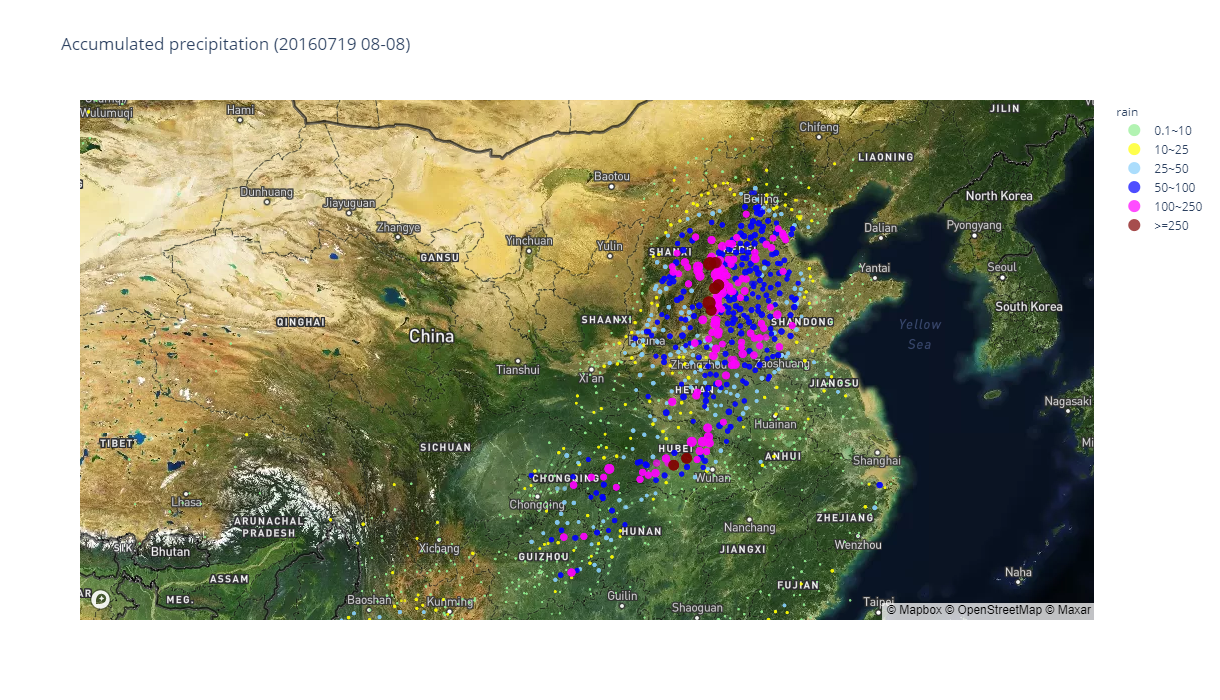

In [57]:
# draw rainfall
bins = [0.1, 10, 25, 50, 100, 250, 1200]
keys = ['0.1~10', '10~25', '25~50', '50~100', '100~250', '>=250']
cols = ['lightgreen', 'yellow', 'lightskyblue', 'blue', 'magenta','maroon']
cols_map = dict(zip(keys, cols))

data['rain'] = pd.cut(data['PRE_Time_0808'], bins=bins, labels=keys)
data['Rainfall'] = '('+data['Lon'].round(2).astype(str) + ',' + data['Lat'].round(2).astype(str) + '): ' + data['PRE_Time_0808'].astype(str)
data['rain_size'] = data['PRE_Time_0808'] + data['PRE_Time_0808'].mean()
df = data[data['rain'].notna()]
fig = px.scatter_mapbox(
    df, lat="Lat", lon="Lon", color="rain", category_orders={'rain': keys}, color_discrete_map = cols_map,
    hover_data={'Rainfall':True, 'Lon':False, 'Lat':False, 'rain':False, 'PRE_Time_0808':False},
    mapbox_style='satellite-streets', size="rain_size", center={'lat':35, 'lon':110}, size_max=10, zoom=4,
    title = 'Accumulated precipitation ({})'.format(date_obj.strftime("%Y%m%d 08-08")),
    width=900, height=700)

fig.show()

In [56]:
data['PRE_Time_0808'].mean()

18.35525667351128

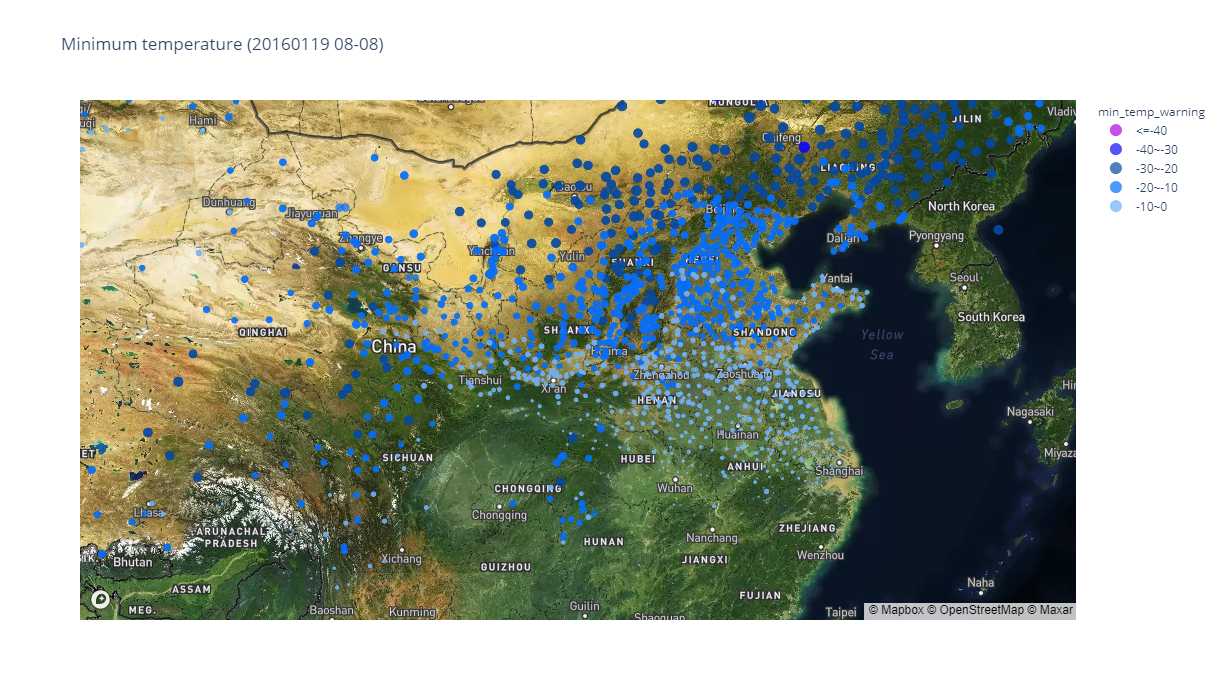

In [36]:
# draw high temperature
bins = [-120, -40, -30, -20, -10, 0]
keys = ['<=-40','-40~-30', '-30~-20', '-20~-10', '-10~0']
cols = ['rgb(178,1,223)', 'rgb(8,7,249)', 'rgb(5,71,162)', 'rgb(5,109,250)', 'rgb(111,176,248)']
cols_map = dict(zip(keys, cols))

data['min_temp_warning'] = pd.cut(data['TEM_Min'], bins=bins, labels=keys)
data['min_temp'] = '('+data['Lon'].round(2).astype(str) + ',' + data['Lat'].round(2).astype(str) + '): ' + data['TEM_Min'].astype(str)
df = data[data['min_temp_warning'].notna()]
if df.shape[0] >= 2:
    fig = px.scatter_mapbox(
        df, lat="Lat", lon="Lon", color="min_temp_warning", category_orders={'min_temp_warning': keys}, color_discrete_map = cols_map,
        hover_data={'min_temp':True, 'Lon':False, 'Lat':False, 'min_temp_warning':False, 'TEM_Min':False},
        mapbox_style='satellite-streets', size=-1.0*df["TEM_Min"], center={'lat':35, 'lon':110}, size_max=10, zoom=4,
        title = 'Minimum temperature ({})'.format(date_obj.strftime("%Y%m%d 08-08")),
        width=900, height=700)

    fig.show()

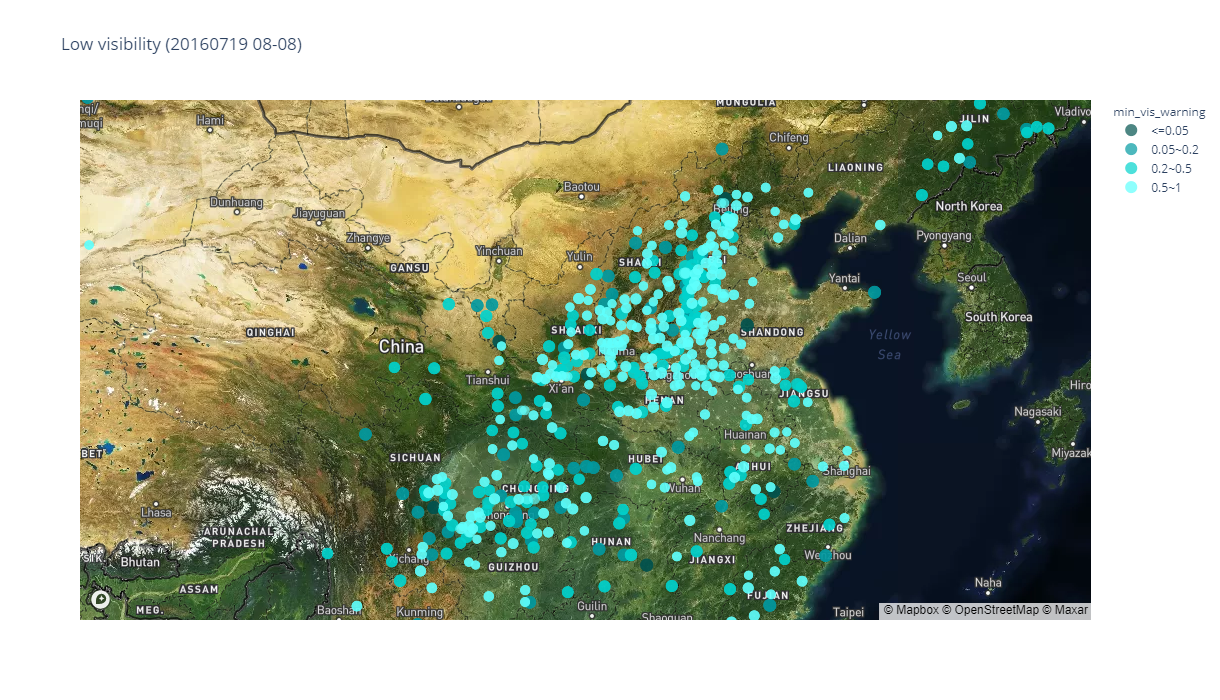

In [67]:
# draw low visibility
bins = [0, 0.05, 0.2, 0.5, 1]
keys = ['<=0.05','0.05~0.2', '0.2~0.5', '0.5~1']
cols = ['rgb(0,82,77)', 'rgb(0,153,160)', 'rgb(0,210,204)', 'rgb(95,255,252)']
cols_map = dict(zip(keys, cols))
data['min_vis_warning'] = pd.cut(data['VIS_Min'], bins=bins, labels=keys)
data['VIS_Min_size'] = 2.0 - data["VIS_Min"]
data['min_vis'] = '('+data['Lon'].round(2).astype(str) + ',' + data['Lat'].round(2).astype(str) + '): ' + \
                  data['VIS_Min'].astype(str)
df = data[data['min_vis_warning'].notna()]
if df.shape[0] >= 2:
    fig = px.scatter_mapbox(
        df, lat="Lat", lon="Lon", color="min_vis_warning", category_orders={'min_vis_warning': keys}, 
        color_discrete_map = cols_map,
        hover_data={'min_vis':True, 'Lon':False, 'Lat':False, 'min_vis_warning':False, 'VIS_Min_size':False},
        mapbox_style='satellite-streets', size="VIS_Min_size", center={'lat':35, 'lon':110}, size_max=10, zoom=4,
        title = 'Low visibility ({})'.format(date_obj.strftime("%Y%m%d 08-08")),
        width=900, height=700)

    fig.show()

In [66]:
df

Station_Id_C      Lat       Lon      Alti  TEM_Max  TEM_Min  VIS_Min  \
8           57129  32.9833  107.7167  447.3999     31.9     22.4    0.817   
11          57129  32.9833  107.7167  447.3999     31.9     22.4    0.817   
19          54514  39.8666  116.2500   55.2000     27.3     23.5    0.583   
21          54514  39.8666  116.3667   55.2000     27.3     23.5    0.583   
24          58006  34.3833  115.8794   47.7999     28.9     25.1    0.621   
...           ...      ...       ...       ...      ...      ...      ...   
4845        58731  27.9166  118.5333  276.8999     33.2     22.1    0.705   
4858        56494  28.8394  104.1500  386.5000     35.4     24.1    0.213   
4862        57137  33.3166  108.3167  802.4000     29.6     21.3    0.963   
4873        56494  28.8394  104.1500  386.5000     35.4     24.1    0.213   
4875        57137  33.3166  108.3167  802.4000     29.6     21.3    0.963   

      PRE_Time_0808  SPRE_Time_0808  WIN_S_Max min_vis_warning  VIS_Min_size  \
8               0.1             NaN        2.6           0.5~1           NaN   
11              0.1             NaN        2.6           0.5~1           NaN   
19             58.6             NaN        2.7           0.5~1         1.042   
21             58.6             NaN        2.7           0.5~1           NaN   
24             72.1             NaN        4.0           0.5~1         1.042   
...             ...             ...        ...             ...           ...   
4845            0.0             NaN        4.7           0.5~1         1.149   
4858            0.0             NaN        9.0         0.2~0.5           NaN   
4862           15.6             NaN        3.5           0.5~1           NaN   
4873            0.0             NaN        9.0         0.2~0.5           NaN   
4875           15.6             NaN        3.5           0.5~1           NaN   

                    min_vis  
8     (107.72,32.98): 0.817  
11    (107.72,32.98): 0.817  
19    (116.25,39.87): 0.583  
21    (116.37,39.87): 0.583  
24    (115.88,34.38): 0.621  
...                     ...  
4845  (118.53,27.92): 0.705  
4858  (104.15,28.84): 0.213  
4862  (108.32,33.32): 0.963  
4873  (104.15,28.84): 0.213  
4875  (108.32,33.32): 0.963  

[1026 rows x 13 columns]

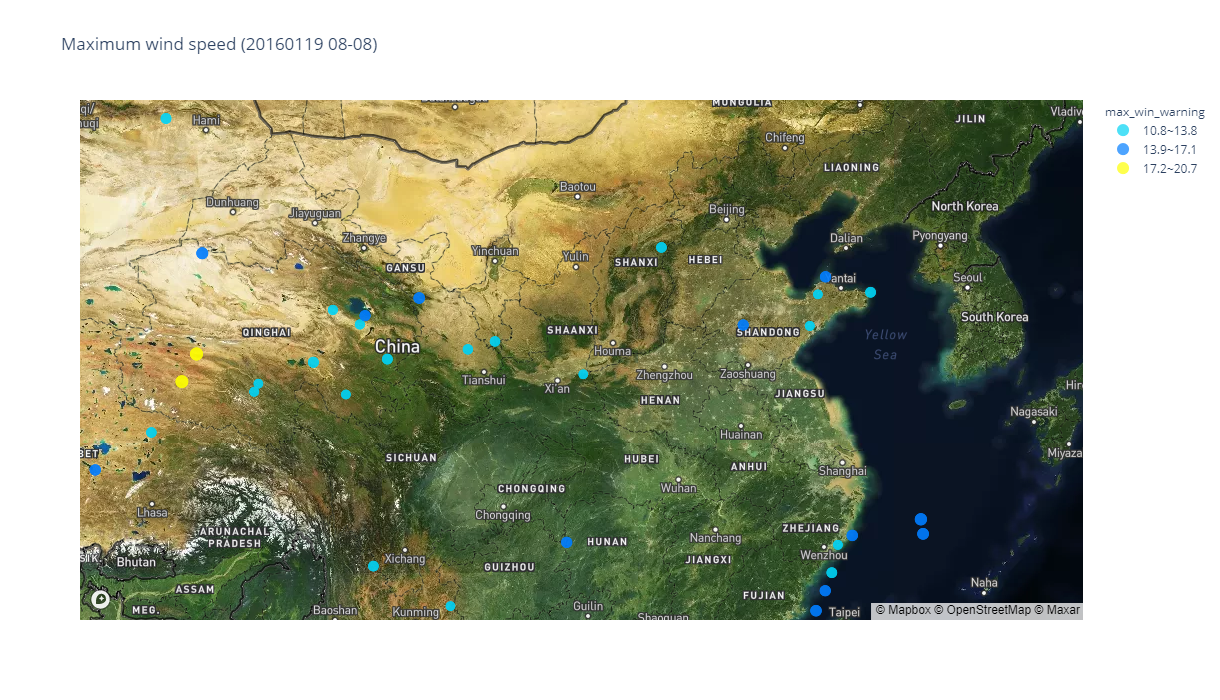

In [48]:
# draw high wind
bins = [10.8, 13.9, 17.2, 20.8, 24.5, 28.5, 32.7, 37.0, 120]
keys = ['10.8~13.8','13.9~17.1', '17.2~20.7', '20.8~24.4', '24.5~28.4', '28.5~32.6', '32.7~36.9', '>=37.0']
cols = ['rgb(0,210,244)', 'rgb(0,125,255)', 'rgb(253,255,0)', 'rgb(247,213,0)',
        'rgb(255,141,0)', 'rgb(251,89,91)', 'rgb(255,3,0)', 'rgb(178,1,223)']
cols_map = dict(zip(keys, cols))

data['max_win_warning'] = pd.cut(data['WIN_S_Max'], bins=bins, labels=keys)
data['max_win'] = '('+data['Lon'].round(2).astype(str) + ',' + data['Lat'].round(2).astype(str) + '): ' + data['WIN_S_Max'].astype(str)
df = data[data['max_win_warning'].notna()]
if df.shape[0] >= 2:
    fig = px.scatter_mapbox(
        df, lat="Lat", lon="Lon", color="max_win_warning", category_orders={'max_win_warning': keys}, color_discrete_map = cols_map,
        hover_data={'max_win':True, 'Lon':False, 'Lat':False, 'max_win_warning':False, 'WIN_S_Max':False},
        mapbox_style='satellite-streets', size="WIN_S_Max", center={'lat':35, 'lon':110}, size_max=10, zoom=4,
        title = 'Maximum wind speed ({})'.format(date_obj.strftime("%Y%m%d 08-08")),
        width=900, height=700)

    fig.show()

In [35]:
df

Station_Id_C      Lat       Lon    Alti  TEM_Max  TEM_Min  VIS_Min  \
0           58240  32.6833  119.0078    21.3      3.0     -4.9   3364.0   
1           58414  30.4333  116.3167   105.1      6.6     -0.2   2252.0   
2           58225  32.5333  117.6778    69.6      3.8     -5.7   1906.0   
3           58421  30.6333  117.8647    31.0      7.6     -1.3   1253.0   
7           58234  32.4666  118.4567    40.4      3.6     -5.8   1702.0   
...           ...      ...       ...     ...      ...      ...      ...   
4864        57131  34.4333  108.9667   410.0      1.8     -5.8   6714.0   
4867        57274  32.7000  112.2161   107.6      7.2     -5.3      NaN   
4868        57390  31.7999  114.0744   733.5      4.9     -3.3   7607.0   
4871        56777  25.1144  102.0997  1671.4     18.8      0.0      NaN   
4873        56478  28.3000  102.4331  1818.1     16.4     -0.4   2920.0   

      PRE_Time_0808  SPRE_Time_0808  WIN_S_Max min_temp_warning  \
0               0.0             NaN        2.3            -10~0   
1               0.0             NaN        8.1            -10~0   
2               0.0             NaN        3.1            -10~0   
3               0.0             NaN        6.3            -10~0   
7               0.0             NaN        3.1            -10~0   
...             ...             ...        ...              ...   
4864            0.8             NaN        6.0            -10~0   
4867            0.0             NaN        3.6            -10~0   
4868            0.0             NaN        4.9            -10~0   
4871            0.0             NaN        6.8            -10~0   
4873            0.0             NaN        7.1            -10~0   

                  min_temp  
0     (119.01,32.68): -4.9  
1     (116.32,30.43): -0.2  
2     (117.68,32.53): -5.7  
3     (117.86,30.63): -1.3  
7     (118.46,32.47): -5.8  
...                    ...  
4864  (108.97,34.43): -5.8  
4867   (112.22,32.7): -5.3  
4868   (114.07,31.8): -3.3  
4871    (102.1,25.11): 0.0  
4873   (102.43,28.3): -0.4  

[3067 rows x 12 columns]

In [20]:
stringA = "interfaceId=getSurfEleByTime&userId=USR_DAVE2004&dataCode=SURF_CHN_PRE_MIN&timestamp=1591003330015&nonce=57d5c503-e1c6-4eb2-8fb5-21fda3dcafb9"

stringSignTemp = stringA + '&pwd=DaiKan19988444'
stringSignTemp = stringSignTemp.split("&")
stringSignTemp.sort()
stringSignTemp = "&".join(stringSignTemp)

stringSignTemp

import hashlib
hl = hashlib.md5()
hl.update(stringSignTemp.encode(encoding='utf-8'))
hl.hexdigest()

In [10]:
from nmc_met_io.config import CONFIG

In [14]:
CONFIG['CMADaaS']['DNS']

'10.40.17.54'

In [21]:
from nmc_met_io.retrieve_cmadaas import cmadaas_obs_by_time
import datetime
date_obj = datetime.datetime(2016, 7, 19)
data = cmadaas_obs_by_time(
    date_obj.strftime('%Y%m%d000000'), data_code="SURF_CHN_MUL_DAY", sta_levels="011,012,013",
    elements="Station_Id_C,Lat,Lon,Alti,TEM_Max,TEM_Min,VIS_Min,PRE_Time_0808,SPRE_Time_0808,WIN_S_Max")

http://10.40.17.54/music-ws/api?serviceNodeId=NMIC_MUSIC_CMADAAS&userId=USR_DAVE2004&pwd=123Qweasdzxc&interfaceId=getSurfEleByTime&dataCode=SURF_CHN_PRE_MIN&elements=Station_Id_C,Lat,Lon&times=20200531000000&limitCnt=10&dataFormat=json